In [1]:
import pandas as pd
#load
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge
combined_data = transactions.merge(customers, on='CustomerID', how='left')

#display1
print(combined_data.head())

  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price     CustomerName         Region  SignupDate  
0      300.68  300.68   Andrea Jenkins         Europe  2022-12-03  
1      300.68  300.68  Brittany Harvey           Asia  2024-09-04  
2      300.68  300.68  Kathryn Stevens         Europe  2024-04-04  
3      601.36  300.68  Travis Campbell  South America  2024-04-11  
4      902.04  300.68    Timothy Perez         Europe  2022-03-15  


In [3]:
#feature Engineering
# Convert TransactionDate to datetime
combined_data['TransactionDate'] = pd.to_datetime(combined_data['TransactionDate'])

# Calculate total spend per customer
customer_spend = combined_data.groupby('CustomerID')['TotalValue'].sum().reset_index()
customer_spend.rename(columns={'TotalValue': 'TotalSpend'}, inplace=True)

# Calculate transactions per customer
total_transactions = combined_data.groupby('CustomerID')['TransactionID'].count().reset_index()
total_transactions.rename(columns={'TransactionID': 'TotalTransactions'}, inplace=True)

# Calculate average transaction value
avg_transaction_value = combined_data.groupby('CustomerID')['TotalValue'].mean().reset_index()
avg_transaction_value.rename(columns={'TotalValue': 'AvgTransactionValue'}, inplace=True)

# Calculate days since last purchase
recency = combined_data.groupby('CustomerID')['TransactionDate'].max().reset_index()
recency['Recency'] = (combined_data['TransactionDate'].max() - recency['TransactionDate']).dt.days
recency = recency[['CustomerID', 'Recency']]

# Merge all features 
customer_features = customer_spend.merge(total_transactions, on='CustomerID')
customer_features = customer_features.merge(avg_transaction_value, on='CustomerID')
customer_features = customer_features.merge(recency, on='CustomerID')

# display
print(customer_features.head())

  CustomerID  TotalSpend  TotalTransactions  AvgTransactionValue  Recency
0      C0001     3354.52                  5              670.904       55
1      C0002     1862.74                  4              465.685       25
2      C0003     2725.38                  4              681.345      125
3      C0004     5354.88                  8              669.360        4
4      C0005     2034.24                  3              678.080       54


In [4]:
#Clustering Using K-Means
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Normalizing the features
scaler = StandardScaler()
customer_features_scaled = scaler.fit_transform(customer_features[['TotalSpend', 'TotalTransactions', 'AvgTransactionValue', 'Recency']])

# Applying K-Means Clustering (can choose 2 - 10 clusters)
kmeans = KMeans(n_clusters=5, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(customer_features_scaled)

# display
print(customer_features[['CustomerID', 'Cluster']].head())

  CustomerID  Cluster
0      C0001        1
1      C0002        3
2      C0003        1
3      C0004        0
4      C0005        3


In [5]:
#Evaluate Clustering
#Using Davies bouldin index to evaluate the clustering quality
from sklearn.metrics import davies_bouldin_score

# Calculate the DBI
db_index = davies_bouldin_score(customer_features_scaled, customer_features['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')

Davies-Bouldin Index: 1.0925130156145169


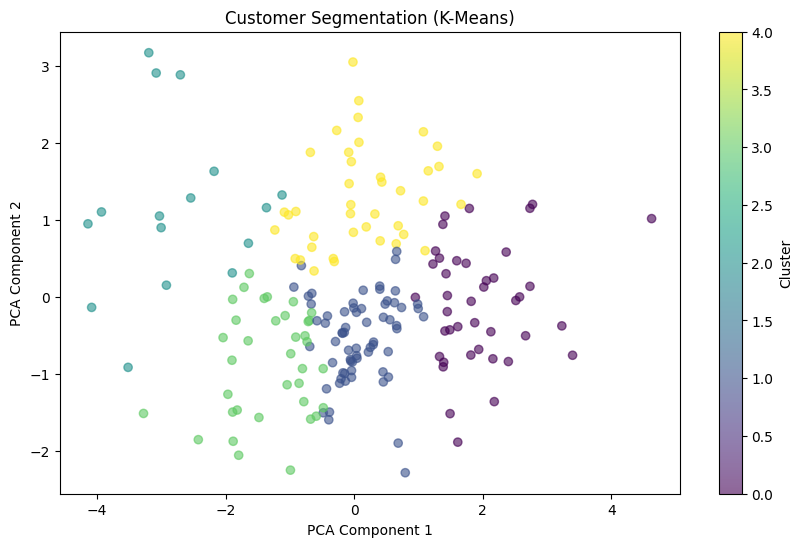

In [6]:
#2D Visualizing the clusters
from sklearn.decomposition import PCA

#dimenion reduction to 2D
pca = PCA(n_components=2)
customer_features_pca = pca.fit_transform(customer_features_scaled)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(customer_features_pca[:, 0], customer_features_pca[:, 1], c=customer_features['Cluster'], cmap='viridis', alpha=0.6)
plt.title('Customer Segmentation (K-Means)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [7]:
customer_features[['CustomerID', 'Cluster']].to_csv('customer_segmentation.csv', index=False)

In [8]:
#revlevant clustering metrics
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(customer_features_scaled, customer_features['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.2737232406025137


In [9]:
#calculating no.of clusters
labels = kmeans.labels_
n_clusters = len(set(labels))  
print(f"Number of clusters formed: {n_clusters}")

Number of clusters formed: 5


In [10]:
#calculating the cluster sizes
cluster_sizes = pd.Series(labels).value_counts()
print("Cluster sizes:\n", cluster_sizes)

Cluster sizes:
 1    66
0    41
4    40
3    36
2    16
Name: count, dtype: int64


In [11]:
inertia = kmeans.inertia_
print(f'Inertia for the model with {4} clusters: {inertia}')

Inertia for the model with 4 clusters: 266.0258254327874


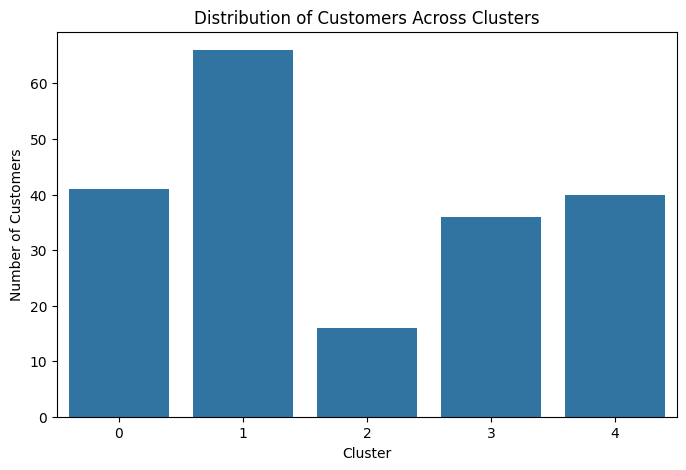

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
cluster_sizes = customer_features['Cluster'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values)
plt.title('Distribution of Customers Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.show()